# Tutorial: Bunny Hill

This iPython notebook gives an absolute-beginners tutorial on using PySHRED. The dataset we consider is weekly mean sea-surface temperature as given by the [NOAA Optimum Interpolation SST V2 dataset](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

In [9]:
# # Install the latest version of PySHRED from GitHub
# # and restart the kernel to ensure the correct package version is used
# import IPython
# !pip install git+https://github.com/pyshred-dev/pyshred.git
# IPython.Application.instance().kernel.do_shutdown(restart=True)

### 🌊 Loading sea surface temperature (SST) data

In [10]:
# !pip install -q gdown
import gdown
import numpy as np

#gdown.download("https://drive.google.com/uc?id=1FCLokoQ8XWKMUSwESQfzbYLe1sEGV5sI", "sst_data.npy", quiet=False)
data = np.load("sst_data.npy")

### Understanding and visualizing SST Data

The `data` variable is a 3D NumPy array containing weekly sea surface temperature values.

* **axis 0:** weekly timestep (timesteps)
* **axis 1:** latitude (180 grid points)
* **axis 2:** longitude (360 grid points)

Each slice `data[t]` is a 2D array representing global SST for week `t`.

Shape of SST data: (1400, 180, 360)


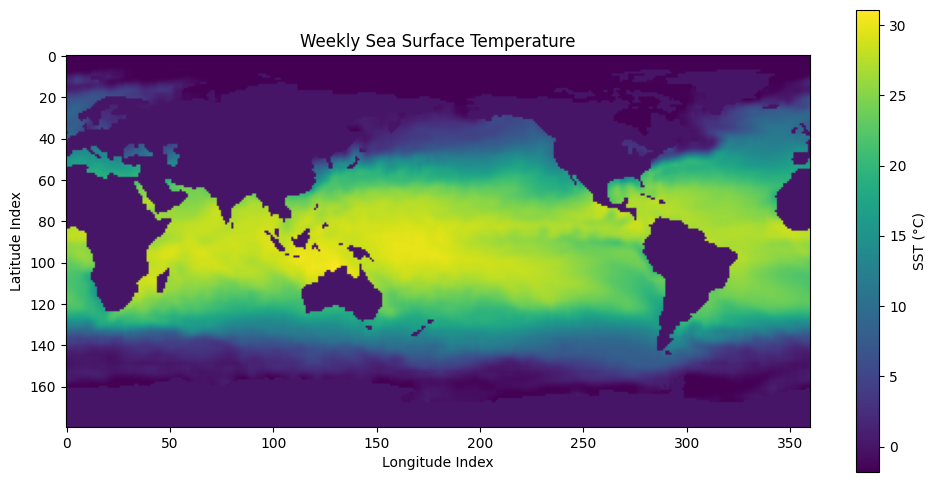

In [11]:
# Print the shape of the array and plot the SST map for the first available week.

import matplotlib.pyplot as plt

# Print shape of SST data
print("Shape of SST data:", data.shape)  # (time, lat, lon)

# Plot the first week's SST values
plt.figure(figsize=(12, 6))
plt.imshow(data[0])
plt.colorbar(label='SST (°C)')
plt.title("Weekly Sea Surface Temperature")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()


### Initialize the data manager

The `DataManager` handles preprocessing and splitting of your dataset into training, validation, and test sets.

In [12]:
from pyshred import DataManager, SHRED, SHREDEngine

manager = DataManager(
    lags=52,          # 1 year of weekly history as input
    train_size=0.8,   # 80% for training
    val_size=0.1,     # 10% for validation
    test_size=0.1     # 10% for testing
)

c:\Users\Berkan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pysindy\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


### Add datasets to data manager

The `DataManager` provides an `add_data()` method for registering datasets to be used with SHRED.

In [13]:
manager.add_data(
    data=data,         # 3D array (time, lat, lon); time must be on axis 0
    id="SST",          # Unique identifier for the dataset
    random=3,          # Randomly select 3 sensor locations
    compress=False     # Keep original spatial resolution (no compression)
)

### Data manager attributes

The `DataManager` exposes several useful attributes to inspect the sensor configuration and measurements.

- `sensor_summary_df`: a DataFrame summarizing metadata for each sensor
- `sensor_measurements_df`: a time-indexed Dataframe containing the raw sensor measurements for all selected sensors.

In [14]:
manager.sensor_summary_df

,data id,sensor_number,type,loc/traj
0,SST,0,stationary (random),"(163, 85)"
1,SST,1,stationary (random),"(104, 137)"
2,SST,2,stationary (random),"(149, 114)"


In [15]:
manager.sensor_measurements_df

,SST-0,SST-1,SST-2
0,-0.0,29.799999,3.07
1,-0.0,29.869999,3.30
2,-0.0,30.769999,3.80
3,-0.0,30.639999,4.10
4,-0.0,30.499999,3.87
...,...,...,...
1395,-0.0,27.719999,-0.86
1396,-0.0,28.139999,-0.56
1397,-0.0,28.569999,-0.48
1398,-0.0,28.239999,-0.61


### Generate train, validation, and test set

The `DataManager` provides a `.prepare()` method for generating the train, validation, and test set for SHRED.

Run the code below to generate train, validation, and test sets.

In [16]:
train_dataset, val_dataset, test_dataset= manager.prepare()

### Initialize SHRED

The SHRED architecture is composed of three core modules:

- `sequence_model`: Encodes temporal patterns in the sensor measurements
- `decoder_model`: Reconstructs the full system state from the latent representation
- `latent_forecaster`: Predicts future latent states from current ones

The simplest way to initialize SHRED is by passing preset model names as strings for each component.
Below we use the default pairing that performs well across many datasets.

In [17]:
shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

### Fit SHRED

The `SHRED` object provides a `.fit()` method for training the shred model using the training and validation datasets. It returns a list of validation errors (MSE) recorded after each epoch.

In [18]:
val_errors = shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=1,
    verbose=True
)

print('val_errors:', val_errors)

Fitting SHRED...
Epoch 1: Average training loss = 0.078789
Validation MSE (epoch 1): 0.036220
val_errors: [0.03622022]


### Evaluate SHRED

The `SHRED` object provides an `.evaluate()` method that computes the mean squared error (MSE) between the model’s reconstruction and the target values in a given dataset.

This is useful for monitoring training progress or for comparing performance across different SHRED models.

**Note:** The target in this evaluation is not the raw ground truth. Instead, it reflects the target produced by the DataManager after preprocessing (e.g. compression, stacking datasets, scaling).

If you want to compare reconstructions directly against the full-resolution ground truth, use the `SHREDEngine`’s `evaluate()` method, as described later in this tutorial.

In [19]:
train_mse = shred.evaluate(dataset=train_dataset)
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Train MSE: 0.034
Val   MSE: 0.036
Test  MSE: 0.041


### Initialize SHRED engine for downstream tasks

The `SHREDEngine` object wraps the trained `SHRED` model and the associated `DataManager`, providing a simple interface for performing downstream sensing tasks such as:

- generating latent space states from sensor measurements
- forecasting future latent space states
- decoding latent space to full-state space
- evaluating full-state reconstructions from sensor measurements against the ground-truth

In [20]:
engine = SHREDEngine(manager, shred)

### Generate latent space states from sensor measurements

The `SHREDEngine` object provides a `.sensor_to_latent()` method for generating the latent space associated with the raw sensor measurements.

In [21]:
# obtain latent space of test sensor measurements
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

### Forecast future latent space states

The `SHREDEngine` provides a `.forecast_latent()` method that predicts future latent states starting from an initial sequence of latent vectors.

In [22]:
 # generate latent states from validation sensor measurements
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)

# seed the forecaster with the final `seed_length` latent states from validation
init_latents = val_latents[-shred.latent_forecaster.seed_length:] # seed forecaster with final lag timesteps of latent space from val

# set forecast horizon to match the length of the test dataset
h = len(manager.test_sensor_measurements)

# forecast latent states for the test horizon
test_latent_from_forecaster = engine.forecast_latent(h=h, init_latents=init_latents)

### Decode Latent Space to Full-State Space

The `SHREDEngine` provides a `.decode()` method for converting latent representations back into the full-state space.

In [23]:
# decode latent space generated from sensor measurements (generated using engine.sensor_to_latent())
test_reconstruction = engine.decode(test_latent_from_sensors)
print(test_latent_from_sensors)

# decode latent space generated by the latent forecaster (generated using engine.forecast_latent())
test_forecast = engine.decode(test_latent_from_forecaster)
print(test_forecast['SST'].shape)

[[-0.00993007 -0.03179343 -0.00842553 ...  0.12651557 -0.147896
  -0.07827112]
 [-0.01299471 -0.03356707 -0.01166753 ...  0.12048202 -0.14867117
  -0.07569066]
 [-0.01729574 -0.03533579 -0.0141238  ...  0.11424288 -0.15049204
  -0.0728555 ]
 ...
 [-0.02248801 -0.03388133 -0.00999619 ...  0.11789897 -0.15091375
  -0.07023782]
 [-0.02383051 -0.03401589 -0.01015365 ...  0.11695097 -0.15121154
  -0.0692856 ]
 [-0.02464218 -0.03404164 -0.01014651 ...  0.11639591 -0.15150818
  -0.06863167]]
(140, 180, 360)


### Evaluate MSE on Ground Truth Data

The `SHREDEngine` provides an `.evaluate()` method that compares reconstructed full-state outputs (from sensor measurements) against the unprocessed ground truth. This includes:

- unscaling the predictions
- project back to full-state space (if compression is used)
- unstacking multiple datasets if more than one was added

In [24]:
# ---------------- Train Evaluation ----------------
t_train = len(manager.train_sensor_measurements)
train_Y = {"SST": data[0:t_train]}  # Ground truth segment
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# ---------------- Validation Evaluation ----------------
t_val = len(manager.val_sensor_measurements)
val_Y = {"SST": data[t_train:t_train + t_val]}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# ---------------- Test Evaluation ----------------
t_test = len(manager.test_sensor_measurements)
test_Y = {"SST": data[-t_test:]}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

# ---------------- Print Results ----------------
print("---------- TRAIN ----------")
print(train_error)

print("\n---------- VALIDATION ----------")
print(val_error)

print("\n---------- TEST ----------")
print(test_error)


---------- TRAIN ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      2.645651  1.626546  0.925334 -0.047491

---------- VALIDATION ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      2.905687  1.704608  0.942754 -1.572501

---------- TEST ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      3.175089  1.781878  1.002324 -1.027069


### Visualize Results
Below we compare the final frame of the test ground truth, the reconstruction from sensor measurements, and the forecast from the latent forecaster.

(180, 360)


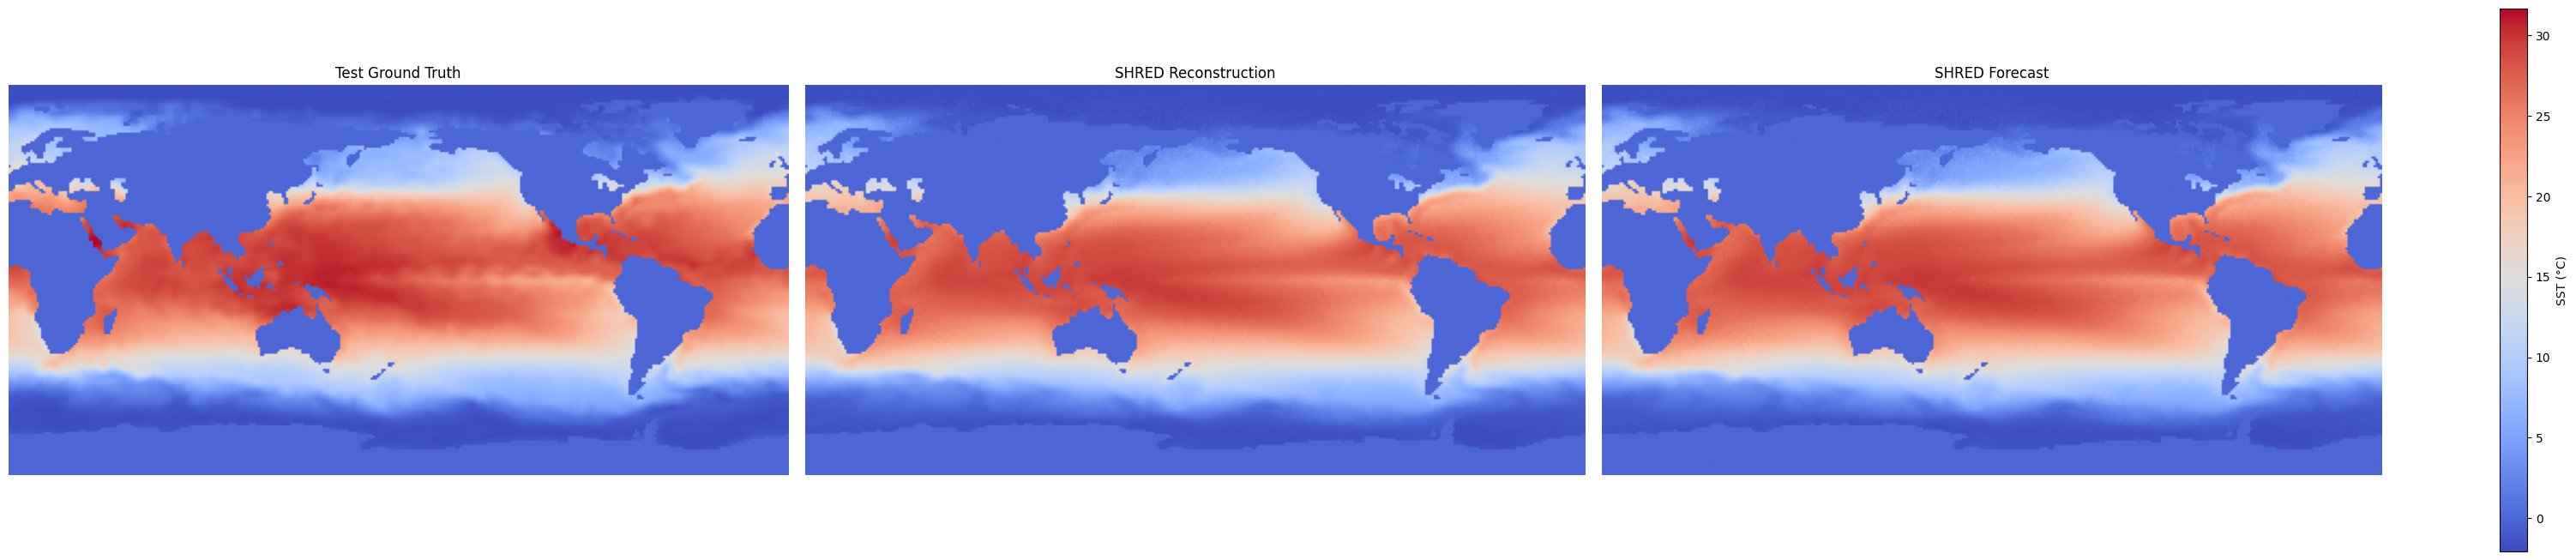

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Final ground truth frame from the test set
truth = data[-1]

# Extract final reconstructed frame (from sensor-based latents)
reconstructions = test_reconstruction["SST"]
reconstruction = reconstructions[h - 1]
print(reconstruction.shape)

# Extract final forecasted frame (from forecasted latents)
forecasts = test_forecast["SST"]
forecast = forecasts[h - 1]

# Collect data and labels for visualization
compare_data = [truth, reconstruction, forecast]
titles = ["Test Ground Truth", "SHRED Reconstruction", "SHRED Forecast"]

# Set shared color scale based on overall data range
vmin = np.min([d.min() for d in compare_data])
vmax = np.max([d.max() for d in compare_data])

# Create side-by-side comparison plot
fig, axes = plt.subplots(1, 3, figsize=(30, 8), constrained_layout=True)

for ax, d, title in zip(axes, compare_data, titles):
    im = ax.imshow(d, vmin=vmin, vmax=vmax, cmap='coolwarm')
    ax.set_title(title)
    ax.axis("off")

# Add shared colorbar
fig.colorbar(im, ax=axes, orientation='vertical', label="SST (°C)", shrink=0.8)
plt.show()
